In [2]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    print(f"accuracy_files: {accuracy_files}")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"\d+", txt_file)[0])
        # Get model size
        if "small" in txt_file:
            model_size = "small"
        elif "medium" in txt_file:
            model_size = "medium"
        elif "large" in txt_file:
            model_size = "large"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True)
    df.to_csv(results_file, index=False)
    return df

## Averaging

In [4]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
best_single_model_small = {
    "trial": "best_single_model_small",
    "accuracy": 69.8,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "small",
}
best_single_model_small_df = pd.DataFrame(best_single_model_small, index=[0])
df = pd.concat([df, best_single_model_small_df], ignore_index=True)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

accuracy_files: ['../averaging/averaging_small_ensemble_size4/averaging_small_ensemble_size4_loss=0.793_accuracy.txt', '../averaging/averaging_small_ensemble_size2/averaging_small_ensemble_size2_loss=0.838_accuracy.txt']


,trial,accuracy,loss,ensemble_size,model_size
0,averaging_small_ensemble_size4,72.05,0.793,4,small
1,averaging_small_ensemble_size2,71.05,0.838,2,small
2,best_single_model_small,69.80,0.000,1,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


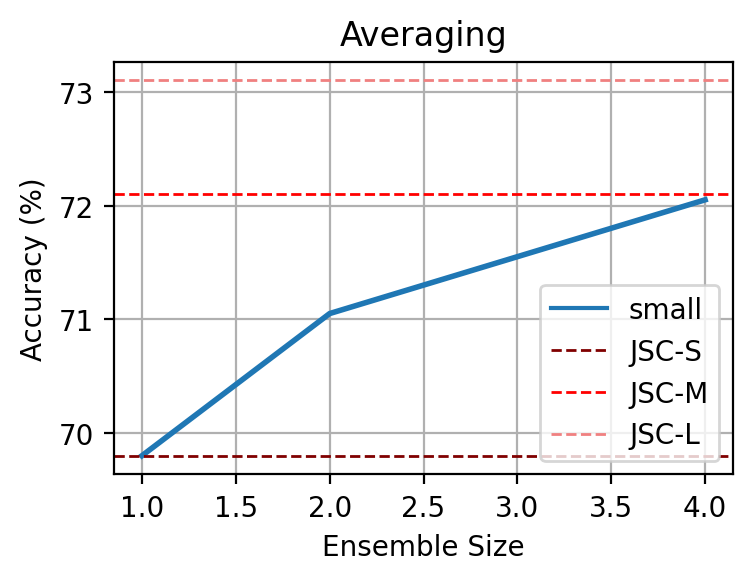

In [10]:
"""
Line plot of accuracy vs ensemble size
"""
fig, ax = plt.subplots(figsize=(4, 3))

# TODO: Sort df by model size to get consistent colored lines per model size
# across ensemble methods

ax = sns.lineplot(
    data=df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
ax.legend()
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")